# **Project - Recommendation Systems: Movie Recommendation System**

## **Marks: 40**
---------------
## **Context**
---------------

Online streaming platforms like **Netflix** have plenty of movies in their repository and if we can build a **Recommendation System** to recommend **relevant movies** to users, based on their **historical interactions**, this would **improve customer satisfaction** and hence, it will also improve the revenue of the platform. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system.

-----------------
## **Objective**
-----------------

In this project we will be building various recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

we are going to use the **ratings** dataset. 

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this case study.

Let's start by mounting the Google drive on Colab.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [4]:
# Installing surprise library
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095451 sha256=6aa9c4d1b44e031a0ce6ba657d92b1ad568cf207306301a798b336ddb535b781
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [5]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [9]:
# Import the dataset
rating = pd.read_csv('/content/drive/MyDrive/datasets/ratings.csv')

Let's check the **info** of the data

In [10]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [11]:
# Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

## **Question 1: Exploring the dataset (7 Marks)**

Let's explore the dataset and answer some basic data-related questions:

###**Q 1.1 Print the top 5 rows of the dataset (1 Mark)**

In [12]:
# Printing the top 5 rows of the dataset Hint: use .head()

rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


This dataset shows a mapping between userId and movieId. It ultimately displays the rating that a particular user makes to a certain movie. 

### **Q 1.2 Describe the distribution of ratings. (1 Mark)**



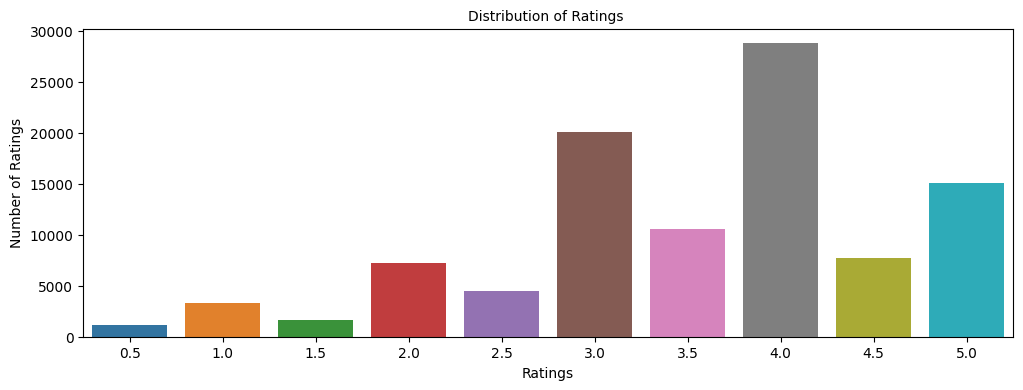

In [14]:
plt.figure(figsize = (12, 4))

sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Write your Answer here:**
* In the above histogram, Rating 4.0 has highest count of ratings. This rating is being made by more than 25k users.
* Rating 3.0 has the second most count of ratings. It reaches approximately 20K * Rating 5.0 is the third in count of ratings with around 15K.
* Users are in general more likely to give ratings in whole numbers.

### **Q 1.3 What is the total number of unique users and unique movies? (1 Mark)**


In [19]:
# Finding number of unique users
rating['userId'].unique().size

671

**Conclusion:**
There are in total 671 different users involved in the dataset.

In [20]:
# Finding number of unique movies

rating['movieId'].unique().size

9066

**Observations:**
* There are in total 9066 different movies involved in this analysis that are available to be chosen and rated.
* It is possible to have in total 671 * 9066 = 6083286 user-movie mappings (ie. there are in total 6083286 ratings) in the dataset.
* But since we only have 100004 known mappings in which a user has rated a movie, therefore we can conclude that, not every user has rated every movie in the dataset.
* We can build a recommendation system to recommend movies to users which they have not interacted with.

### **Q 1.4 Is there a movie in which the same user interacted with it more than once? (1 Mark)**

In [21]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [50]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

**Observations:**
* The sum above equals to the number of entries in the original dataset which implies that **no user rated a movie more than once**.

### **Q 1.5 Which is the most interacted movie in the dataset? (1 Mark)**

In [45]:
rating['movieId'].value_counts().sort_values(ascending=False)

356       341
296       324
318       311
593       304
260       291
         ... 
143377      1
143657      1
146682      1
147845      1
6425        1
Name: movieId, Length: 9066, dtype: int64

In [46]:
rating['movieId'].value_counts().max()

341

**Observations:**
* The movie with movieId 356 has been rated by the highest number of users. There are 341 users rating this movie. Hence, it is the most interacted movie in the dataset.
* But still, there is a possibility of 671-341 = 330 more interactions as we have 671 different users in our dataset. For those 671 remaining users, we can build a recommendation system to predict who is most likely to interact with this movie.

Also, out of these 330 interactions, we need to consider the distribution of ratings as well.

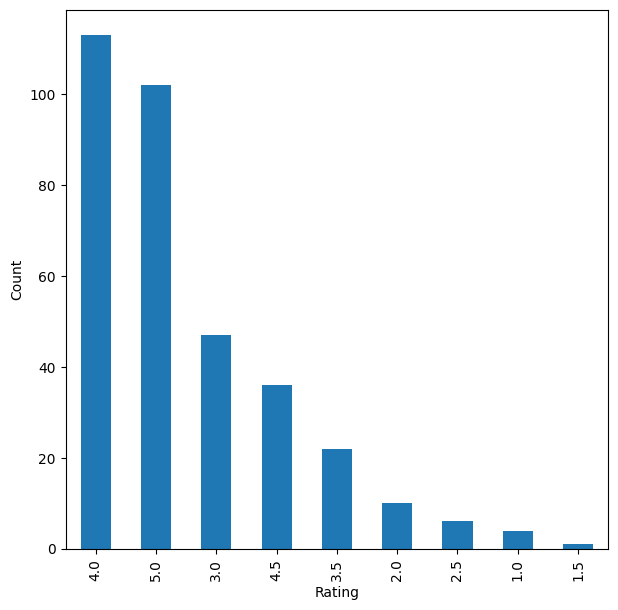

In [51]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

**Observations:**
* We can see that this movie has been liked by the majority of users, as the count of ratings 4.0 and 5.0 is higher than the count of other ratings.
* There can be items with very high interactions but the count of lower ratings ranging from 1.0 to 2.0 for example may be much higher than 4.0 or 5.0 which would imply that the movie may be potentially disliked by the majority of users (given the unknown interactions that the remaining 330 users would make).



### **Q 1.6 Which user interacted the most with any movie in the dataset? (1 Mark)**

In [53]:
rating['userId'].value_counts().sort_values(ascending=False)

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
76       20
35       20
651      20
657      20
1        20
Name: userId, Length: 671, dtype: int64

In [54]:
rating['userId'].value_counts().max()

2391

**Observations:**
* The user with userId 547 has interacted 2391 times with the movies which has interacted the most with any movie among other users in the dataset.
* But still, there is a possibility of 9066-2391 = 6675 more interactions as we have 9066 different movies in our dataset. For those 6675 remaining movies, we can build a recommendation system to predict which items are most likely to be watched by this user.

### **Q 1.7 What is the distribution of the user-movie interactions in this dataset? (1 Mark)**

In [56]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

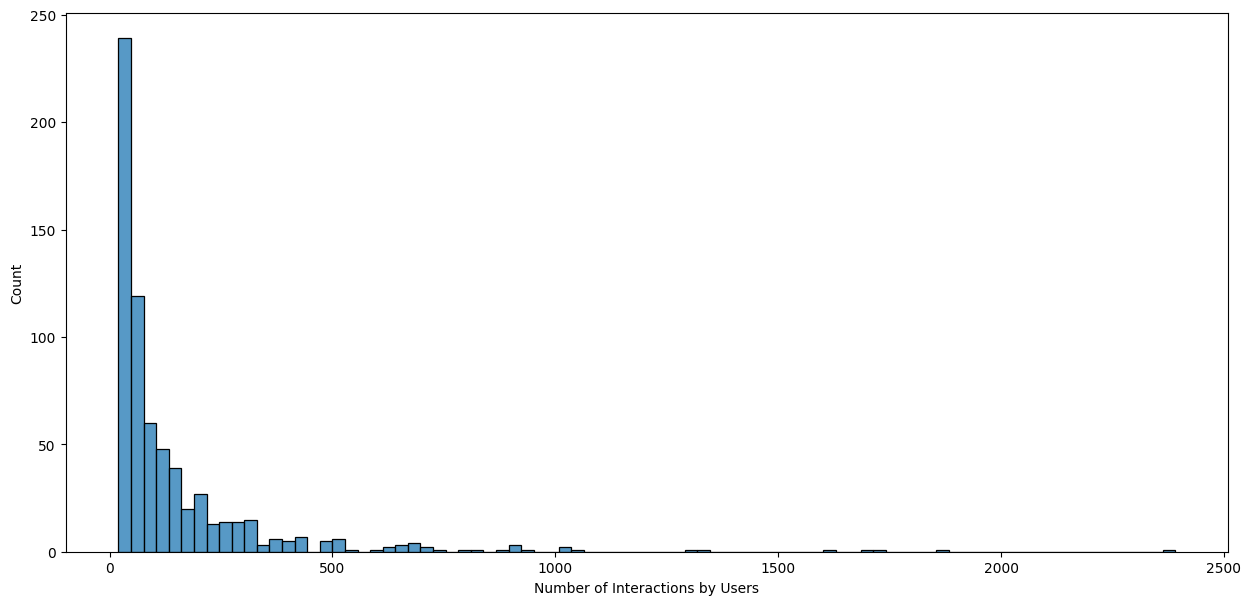

In [57]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Observations:**
* The distribution is higher skewed to the right. Only a few users rated a movie with more than 500 items.

#### As we have now explored the data, let's start building Recommendation systems

## **Question 2: Create Rank-Based Recommendation System (3 Marks)**

### **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [58]:
# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [59]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [60]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [61]:
list(top_n_movies(final_rating, 5, min_interaction=50))

[858, 318, 969, 913, 1221]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [62]:
list(top_n_movies(final_rating, 5))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [64]:
list(top_n_movies(final_rating, 5, min_interaction=200))

[858, 318, 50, 527, 608]

Now that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation Systems**.

## **Model 2: User based Collaborative Filtering Recommendation System (7 Marks)**

![collaborative_filtering.PNG](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/collaborative_filtering.PNG)

In the above **interactions matrix**, out of users B and C, which user is most likely to interact with the movie, "The Terminal"?

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

#### **Building Similarity/Neighborhood based Collaborative Filtering**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/cosine.PNG)

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`**. Finally splitting the data into train and test set.

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [65]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [67]:
sim_options = {'name': 'cosine',
               'user_based': True}

# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### **Q 3.1 What is the RMSE for baseline user based collaborative filtering recommendation system? (1 Mark)**

**Conclusion:**
* As we can see from above, these baseline model has RMSE=0.9925 on test set, we will try to improve this number later by using GridSearchCV tuning different hyperparameters of this algorithm

### **Q 3.2 What is the Predicted  rating for a user with userId=4 and for movieId=10 and movieId=3? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [69]:
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

**Observations:**
* The actual rating for this user-movie mapping is 4.
* The predicted rating is 3.62.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [70]:
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

**Observations:**
* The actual rating for this user-movie mapping pair could not be estimated. 
* The estimated rating is 3.20, which is slightly lower than the case when we use movieId=10 for prediction.

### **Improving user-user similarity based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm - 

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

### **Q 3.3 Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system? (3 Marks)**

In [72]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9654952235625057
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [73]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.965106,0.965786,0.965594,0.965495,0.000286,1,0.742329,0.741359,0.743140,0.742276,0.000728,1,0.161592,0.066066,3.769198,0.685664,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.993594,0.994376,0.993965,0.993978,0.000319,14,0.768407,0.767280,0.768893,0.768193,0.000675,12,0.218385,0.041589,2.684139,0.024936,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.971678,0.967792,0.968207,0.969226,0.001742,3,0.746948,0.743664,0.744907,0.745173,0.001354,3,0.121996,0.041759,3.513174,1.057859,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.998074,0.995296,0.995135,0.996168,0.001349,15,0.771445,0.768531,0.769359,0.769779,0.001226,15,0.294806,0.115871,3.348850,0.797625,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.977131,0.974212,0.974490,0.975278,0.001315,7,0.751363,0.749519,0.750151,0.750344,0.000765,7,0.134127,0.010388,2.735761,0.024620,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.



In [74]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd', 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=20, min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9571


0.9571445417153293

**Insights:**
* We can see from above that after tuning hyperparameters, RMSE for testset has slightly reduced to 0.9571 from 0.9925. 
* We can say that we have been able to improve the model after hyperparameter tuning.

### **Q 3.4 What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [75]:
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

**Insights:**
* If we compare the above predicted rating, we can see the baseline model predicted rating as 3.62 and the optimized model predicted the rating as 3.74.

Below we are predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model as shown below - 

In [76]:
similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

**Insights:**
* If we compare the above predicted rating, we can see the baseline model predicted rating as 3.20 and the optimized model predicted the rating as 3.72.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [77]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[665, 417, 647, 654, 260]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [78]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [79]:
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

### **Q 3.5 Predict the top 5 movies for userId=4 with similarity based recommendation system (1 Mark)**

In [80]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

## **Model 3: Item based Collaborative Filtering Recommendation System (7 Marks)**

In [81]:
# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

### **Q 4.1 What is the RMSE for baseline item based collaborative filtering recommendation system ?(1 Mark)**

**Observations:**
* These baseline model has RMSE=1.0032 on test set. 



Let's us now predict rating for an user with `userId=4` and for `movieId=10`

### **Q 4.2 What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3? (1 Mark)**

In [82]:
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

**Observations:**
* The actual rating for this user-movie mapping pair is 4.00.
* The predicted rating is 4.37.
* The estimation is produced under this similarity based baseline model.


Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [83]:
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

**Observations:**
* The actual rating here could not be evaluated.
* The predicted rating here is estimated 4.07.
* The estimation is produced under this similarity based baseline model.


### **Q 4.3 Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system? (3 Marks)**

In [85]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9409098601513252
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [86]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.959895,0.946359,0.951692,0.952649,0.005567,7,0.742616,0.729885,0.732898,0.735133,0.005432,7,5.584927,2.329641,15.207310,2.334665,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.022418,1.009810,1.012221,1.014816,0.005464,16,0.799638,0.785928,0.786552,0.790706,0.006321,16,7.892030,1.707547,13.152718,0.057632,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.960018,0.946605,0.951995,0.952873,0.005511,8,0.742820,0.730058,0.733121,0.735333,0.005440,8,3.353499,0.036683,12.857825,0.226630,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.022635,1.010075,1.012592,1.015101,0.005426,17,0.799889,0.786120,0.786865,0.790958,0.006322,17,6.804691,0.685941,11.557620,0.317590,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.960799,0.947138,0.952301,0.953413,0.005632,9,0.743563,0.730444,0.733374,0.735793,0.005623,9,4.337817,0.750706,11.679050,0.827013,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [87]:
sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options=sim_options, k=40, min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9433


0.9433184999641279

**Observations:**
* After tuning hyperparameters, RMSE for testset has reduced to 0.9433 from 1.0032. 
* We can conclude that we have been able to improve the model after hyperparameter tuning.

### **Q 4.4 What is the Predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [88]:
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

**Insights:**
* If we compare the above predicted rating, we can see the baseline model predicted rating as 4.37 and the optimized model predicted the rating as 4.26. whereas the actual rating is remained 4.0.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [89]:
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

**Insights:**
* If we compare the above predicted rating, we can see the baseline model predicted rating as 4.07 and the optimized model predicted the rating as 3.87, whereas the actual rating in both models couldn't be evaluated.

### **Identifying similar items to a given item (nearest neighbors)**
We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar items to the `movieId=3` based on the `msd` distance metric

In [90]:
similarity_algo_optimized_item.get_neighbors(3, k=5)

[31, 37, 42, 48, 73]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [91]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

### **Q 4.5 Predict the top 5 movies for userId=4 with similarity based recommendation system (1 Mark)**

In [92]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

## **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD (7 Marks)**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data. For example:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

Now if we notice the above movies closely:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF4.PNG)

Here **Action**, **Romance**, **Suspense** and **Comedy** are latent features of the corresponding movies. Similarly, we can compute the latent features for users as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF5.PNG)



### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

First we need to convert the below movie-rating dataset:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

into an user-item matrix as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF6.PNG)

We have already done this above while computing cosine similarities.

**SVD decomposes this above matrix into three separate matrices:**
- U matrix
- Sigma matrix
- V transpose matrix

#### **U-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF7.PNG)

the above matrix is a n x k matrix, where:
- n is number of users
- k is number of latent features

#### **Sigma-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF8.PNG)

the above matrix is a k x k matrix, where:
- k is number of latent features
- Each diagonal entry is the singular value of the original interaction matrix

#### **V-transpose matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF9.PNG)

the above matrix is a kxn matrix, where:
- k is the number of latent features
- n is the number of items

### **Build a baseline matrix factorization recommendation system**

In [93]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9062


0.9061732412066024

### **Q 5.1 What is the RMSE for baseline SVD based collaborative filtering recommendation system? (1 Mark)**

**Insights:**
* The baseline RMSE for matrix factorization model on testset is 0.9062.
* It is lower as compared to the RMSE for baseline similarity based recommendation system (which is 0.9925).
* It is also lesser than the RMSE for optimized similarity based recommendation system (which is 0.9655).

### **Q 5.2 What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [94]:
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.22   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.223382140315308, details={'was_impossible': False})

**Observations:**
* The actual rating is 4.00.
* The estimated rating is 4.22.
* It seems like this matrix factorization based baseline model over estimated the rating by a small margin.
* Hence we need to try to fix this later by tuning the hyperparameters of the model using GridSearchCV.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [95]:
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.65   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.652869269303618, details={'was_impossible': False})

**Observations:**
* The estimated rating here is 3.65.
* The actual rating could not be evaluated here.

### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

### **Q 5.3 Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system? (3 Marks)**

In [96]:
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8943342121552268
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [97]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.941915,0.946284,0.941638,0.943279,0.002128,25,0.740207,0.739518,0.735044,0.738256,0.002289,25,0.793306,0.029583,0.422823,0.011663,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.946400,0.950752,0.945523,0.947558,0.002286,26,0.745090,0.744744,0.739527,0.743120,0.002545,26,0.820013,0.023968,0.419041,0.022736,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.951134,0.955968,0.950798,0.952633,0.002362,27,0.750195,0.750677,0.745192,0.748688,0.002480,27,0.812447,0.026521,0.433759,0.033771,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.905826,0.910543,0.905399,0.907256,0.002331,10,0.703989,0.703976,0.699849,0.702605,0.001949,9,0.935229,0.195215,0.678077,0.187381,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.913414,0.917935,0.912128,0.914492,0.002490,15,0.711792,0.712295,0.707288,0.710458,0.002251,15,1.465655,0.127780,0.664293,0.230988,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [98]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8953


0.8952780977586057

### **Q 5.4 What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using SVD based collaborative filtering? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [99]:
svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.987540484201623, details={'was_impossible': False})

**Insights:**
* If we compare the above predicted rating, we can see the baseline model predicted rating as 4.22 and the optimized model predicted the rating as 3.99. whereas the actual rating is 4.00.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [100]:
svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.64   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6436128972621513, details={'was_impossible': False})

### **Q 5.5 Predict the top 5 movies for userId=4 with SVD based recommendation system?(1 Mark)**

In [101]:
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(1192, 5),
 (3310, 4.9731487450674425),
 (116, 4.953977068299185),
 (926, 4.949755214663542),
 (1948, 4.922591971481249)]

### **Predicting ratings for already interacted movies** 

Below we are comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [102]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

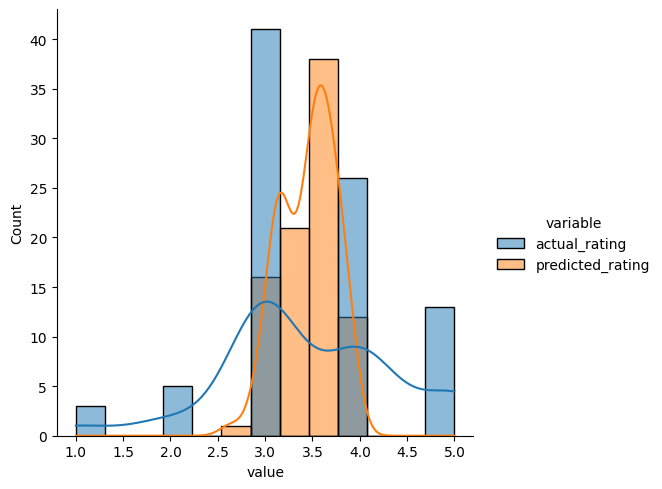

In [103]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

**Observations:**
* The distribution of predicted ratings is closely following the distribution of actual ratings. 
* The total bins for predicted ratings are nearly same as to 
the total bins for actual ratings.
* There are more predicted values in between 3.0 and 4.0.

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

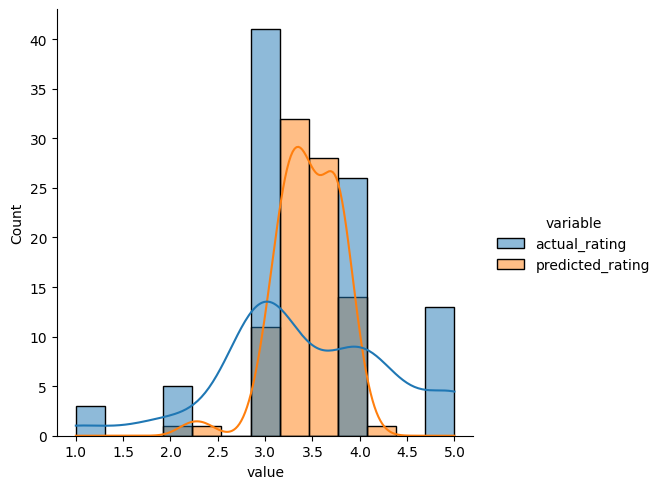

In [104]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [105]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## **Precision and Recall @ k**

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  

**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant movies, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

See the Precision and Recall @ k section of your notebook and follow the instructions to compute various precision/recall values at various values of k.

To know more about precision recall in Recommendation systems refer to these links : 

https://surprise.readthedocs.io/en/stable/FAQ.html

https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

### **Question6: Compute the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values? (4 marks)**

In [106]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [107]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.766
-----> Recall:  0.412
> k=5, model=KNNBasic
-----> Precision:  0.773
-----> Recall:  0.418
> k=5, model=KNNBasic
-----> Precision:  0.607
-----> Recall:  0.327
> k=5, model=KNNBasic
-----> Precision:  0.679
-----> Recall:  0.355
> k=5, model=SVD
-----> Precision:  0.755
-----> Recall:  0.384
> k=5, model=SVD
-----> Precision:  0.747
-----> Recall:  0.384
> k=10, model=KNNBasic
-----> Precision:  0.751
-----> Recall:  0.546
> k=10, model=KNNBasic
-----> Precision:  0.75
-----> Recall:  0.561
> k=10, model=KNNBasic
-----> Precision:  0.595
-----> Recall:  0.474
> k=10, model=KNNBasic
-----> Precision:  0.656
-----> Recall:  0.501
> k=10, model=SVD
-----> Precision:  0.74
-----> Recall:  0.52
> k=10, model=SVD
-----> Precision:  0.73
-----> Recall:  0.519


### **Question 7 ( 5 Marks)**
**7.1 Compare the results from the base line user-user and item-item based models.**

**7.2 How do these baseline models compare to each other with respect to the tuned user-user and item-item models?**

**7.3 The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference. Also, compare the RMSE and precision recall for the models.**

**7.4 Does it improve? Can you offer any reasoning as to why that might be?**

**Insights:**
* User-based and Item-based Collaborative Models have nearly same results. 
* User-based model has RMSE value of 0.9925 initially and RMSE value of 0.9655 after optimizing the model.
* Item-based model has RMSE value of 0.9062 initially and RMSE value of 0.8953 afte optimizing the model.
* Clearly, tuned Collaborative Filtering Models have performed better than baseline model and the user-user based tuned model is performing better.


**Insights:**
* The Collaborative Models use the user-item-ratings data to find similarities and make predictions rather than just predicting a random rating based on the distribution of the data. This could a reason why the Collaborative filtering performed well.

**Insights:**
* Collaborative Filtering searches for neighbors based on similarity of movie preferences and recommendationd that those neighbors (users) interacted/rated. 
* Whereas Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

**Insights:**
* The RMSE of matrix factorization model has been reduced from 0.9062 to 0.8953.
* Tuning SVD matrix factorization model is not improving the base line SVD much.
* The RMSE of Item based collaborative filtering has been reduced from 1.0032 to 0.9433.
* The RMSE of User based collaborative filtering has been reduced from 0.9925 to 0.9571.
* It looks like matrix factorization has the least RMSE compared to other models.
* Matrix Factorization has lower RMSE due to the reason that it assumes that both items and users are present in some low dimensional space describing their properties and recommend a item based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

### **Conclusions**

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.

Here is an article explaining how [Amazon use **A/B Testing**](https://aws.amazon.com/blogs/machine-learning/using-a-b-testing-to-measure-the-efficacy-of-recommendations-generated-by-amazon-personalize/) to measure effectiveness of its recommendation systems.